# Class Activation Map 만들기

## 개요

### 실습 목표

* Classification model로부터 CAM을 얻어낼 수 있다.
* CAM으로 물체의 위치를 찾을 수 있다.
* CAM을 시각화 비교할 수 있다.

### 학습 내용

1. CAM, Grad-CAM용 모델 준비하기
2. CAM
3. Grad-CAM
4. Detection with CAM

## CAM, Grad-CAM용 모델 준비하기 (1) 데이터셋 준비하기

### Libraries 불러오기

* Grad-CAM은 CAM과 달리 CNN 네트워크 뒤에 GAP(Global Average Pooling)이 필요없습니다.
* CAM : 클래스에 대한 활성화 정도를 나타내는 지도 - 분류를 수행하는 모델
* Tensorflow Datasets의 stanford_dogs 데이터셋을 사용 - 120종의 개를 사진으로 판별하는 분류 문제 데이터셋
* 라벨이 위치정보인 bounding box(바운딩 박스) 정보를 포함하고 있습니다.

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import copy
import cv2

* GPU 작동 확인

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### 데이터셋을 다운로드 합니다.

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

2022-10-24 23:12:18.041103: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-24 23:12:18.701780: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6668 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070, pci bus id: 0000:01:00.0, compute capability: 7.5


### 샘플 확인하기

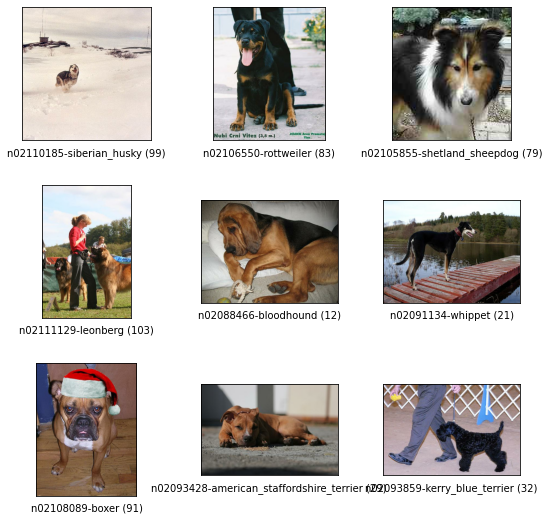

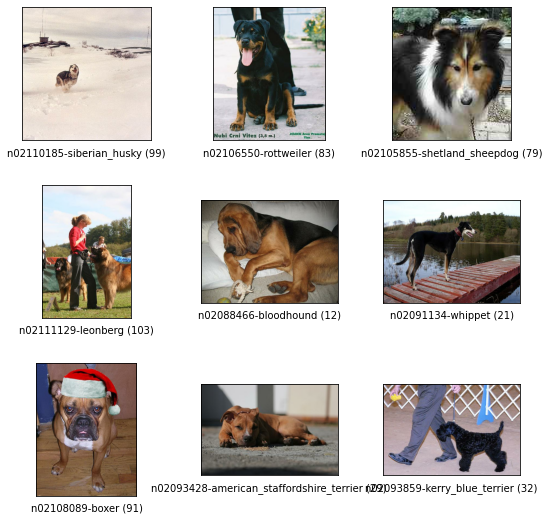

In [4]:
tfds.show_examples(ds_train, ds_info)

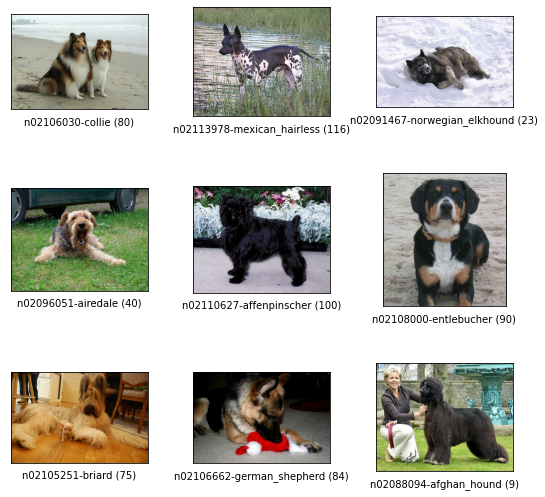

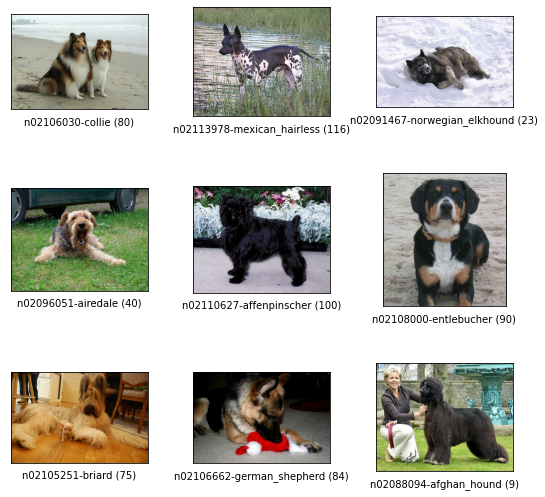

In [5]:
tfds.show_examples(ds_test, ds_info)

## CAM, Grad-CAM용 모델 준비하기 (2) 물체의 위치정보

* feature가 어떻게 구성되어 있는지 확인해 봅시다.

In [6]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})

* 바운딩 박스를 표시하는 방법
1. xywh : Bounding box의 중점을 x, y로 표기하고, 사각형의 너비 w와 높이 h를 표기하는 방법입니다.
   - (x_center, y_center, width, height)
   - x, y가 중심점이 아니라 좌측 상단의 점을 가리킬 수도 있습니다.
2. minmax : Bounding box를 이루는 좌표의 최소값과 최대값을 통해 표기하는 방법입니다.
   - (x_min, x_max, y_min, y_max)
   - 좌표의 절대값이 아니라, 전체 이미지의 너비와 높이를 기준으로 normalize한 상대적인 값을 표기하는게 일반적임.

## CAM, Grad-CAM용 모델 준비하기 (3) CAM을 위한 모델 만들기

* ImageNet 데이터로 훈련된 ResNet50을 기반으로 함.
* pooling layer 뒤에 softmax layer를 붙여 Grad-CAM 모델을 만들겠습니다.

In [7]:
num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet50.ResNet50(
    include_top=False,     # Imagenet 분류기  fully connected layer 제거
    weights='imagenet',
    input_shape=(224, 224,3),
    pooling='avg',      # GAP를 적용  
)
x = base_model.output
preds = keras.layers.Dense(num_classes, activation='softmax')(x)
cam_model = keras.Model(inputs=base_model.input, outputs=preds)

In [8]:
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

## CAM, Grad-CAM용 모델 준비하기 (4) CAM 모델 학습하기

* normalizing과 resizing을 포함한 간단한 전처리 : normalize_and_resize_img()
* apply_normalize_on_dataset()에서 배치를 구성

In [9]:
def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

* 데이터셋에 전처리와 batch 처리를 적용합니다.

In [10]:
# 데이터셋에 전처리와 배치처리를 적용합니다. 
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_test_norm = apply_normalize_on_dataset(ds_test)

# 구성된 배치의 모양을 확인해 봅니다. 
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


* 맛보기로 1 Epoch만 학습해보기
* 나중에는 학습된 가중치를 불러와서 사용할 예정

In [11]:
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

In [12]:
# history_cam_model = cam_model.fit(
#     ds_train_norm,
#     steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
#     validation_steps=int(ds_info.splits['test'].num_examples/16),
#     epochs=1,
#     validation_data=ds_test_norm,
#     verbose=1,
#     use_multiprocessing=True,
# )

* 아래 코드의 주석을 풀면 직접 학습시킨 가중치를 저장할 수 있습니다.

In [13]:
# import os
# cam_model_path = os.getenv('HOME')+'/aiffel/class_activation_map/cam_model1.h5'
# cam_model.save(cam_model_path)
# print("저장 완료!")

## CAM

* 학습된 모델을 위한 CAM을 생성해 볼 것.

In [14]:
# 커널 재시작 이후 실습을 위해, 이전 스텝의 코드를 모아서 한꺼번에 실행합니다.
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import copy
import cv2
from PIL import Image

(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

* CAM 생성
* 생성 작업이 Dataset batch 단위가 아니라 개별 이미지 단위로 이루어지기 때문에
* get_one() 함수로 데이터셋에서 한 장씩 뽑을 수 있도록 합니다.

In [15]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

80


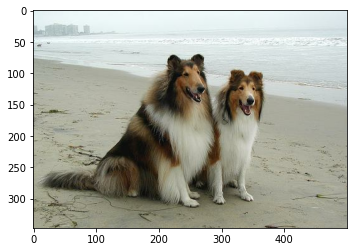

In [16]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

* 보다시피 하나의 이미지가 나옵니다
* 데이터가 준비되었으니 CAM을 생성하기 위해 미리 학습된 모델을 불러옵니다.

In [17]:
import os

# cam_model_path = os.getenv('HOME')+'/aiffel/class_activation_map/cam_model.h5'
cam_model_path = '/home/aiffel/Code/Going_Deeper/Going_Deeper_Project/5/data/cam_model.h5'
cam_model = tf.keras.models.load_model(cam_model_path)

* CAM을 생성하기 위해
1. 특성 맵
2. 클래스별 확률을 얻기 위한 소프트맥스 레이어의 가중치
3. 원하는 클래스의 출력값  
추가로 CAM을 입력 이미지의 크기와 같게 만들어서 반환하는 함수 또한 필요합니다.

* generate_cam()을 구현하기 위해
* convs_outputs와 같이 특정 layer의 결과값을 output으로 받기 위해 새로운 모델을 정의
* feedfoward를 거친 후 CAM을 계산
* 마지막에 입력 이미지에 맞춰 CAM을 resize 해줍니다.

In [18]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    # model.layers[-3].output에서는 우리가 필요로 하는 GAP 이전 Convolution layer의 output을 얻을 수 있습니다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    conv_outputs = conv_outputs[0, :, :, :]
    
    # 모델의 weight activation은 마지막 layer에 있습니다.
    class_weights = model.layers[-1].get_weights()[0] 
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # conv_outputs의 i번째 채널과 i번째 weight를 곱해서 누적하면 활성화된 정도가 나타날 겁니다.
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    return cam_image

2022-10-24 23:12:28.163536: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8204


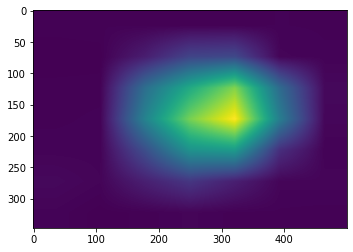

In [19]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

* 그려진 이미지를 원본 이미지와 합쳐봅시다.

In [20]:
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

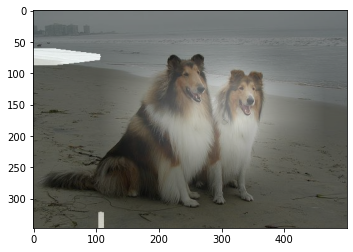

In [21]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

## Grad-CAM

* Grad-CAM의 특성 상 위에서 만든 모델을 다시 사용해도 됩니다.
* 계속해서 cam_model을 활용합시다. 

67


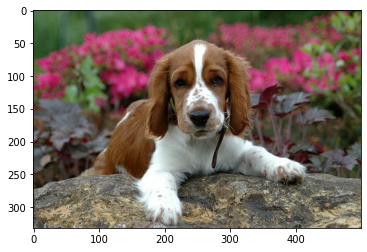

In [22]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

* Grad-CAM은 관찰을 원하는 레이어와 정답 클래스에 대한 예측값 사이의 Gradient을 구합니다.
* 최종 CAM 이미지를 구하기 위해서는 레이어의 채널별 가중치(weights)와 레이어에서 나온 채널별 특성 맵을 가중합하여 cam_image를 얻게 됩니다.

In [23]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0] # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.

    weights = np.mean(grad_val, axis=(0, 1)) # GAP의 역할을 수행한다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # output의 k번째 채널과 k번째 weight를 곱하고 누적해서 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image = tf.math.maximum(0, grad_cam_image)
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

* 결과 확인

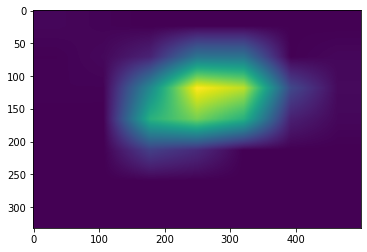

In [24]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

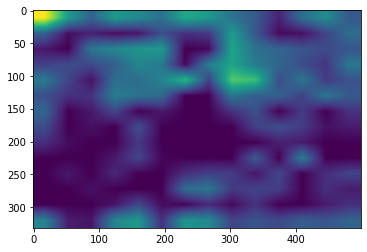

In [25]:
grad_cam_image = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

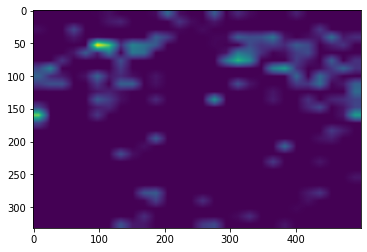

In [26]:
grad_cam_image = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

## Detection with CAM

### Bounding Box

* 새로운 이미지를 뽑아서 CAM 이미지를 뽑아봅시다.

40


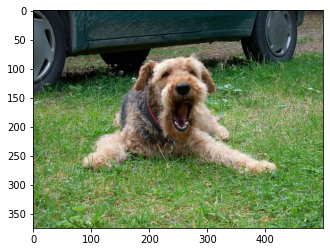

In [27]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

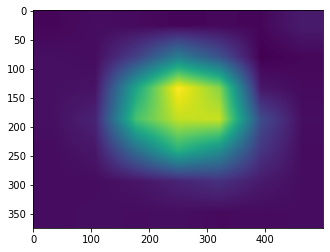

In [28]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

* Bounding box를 만들기 위해 score_thresh를 받아 역치값 이하 바운딩 박스는 없앱니다.
* OpenCV의 findContours()와 minAreaRect()로 사각형을 찾습니다.
* rotated_rect : 회전된 bounding box
* boxPoints로 이를 꼭짓점으로 만들어 줍니다.
* 마지막으로 int형으로 변환해줍니다.

In [29]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

In [30]:
rect = get_bbox(cam_image)
rect

array([[ 63, 262],
       [133,  -8],
       [477,  80],
       [407, 352]])

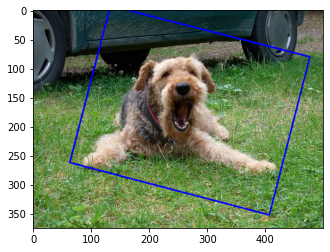

In [31]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

### Intersection Over Union

* IoU를 통해 모델이 영역을 잘잡았는지 확인해봅시다.

In [32]:
# rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어집니다. 
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

* 위에서 구했던 rect를 minmax bbox 형태로 치환해 봅시다.

In [33]:
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[-0.021333333333333333, 0.126, 0.9386666666666666, 0.954]

* 이 데이터의 ground truth bbox를 확인해봅시다.

In [34]:
item['objects']['bbox']

array([[0.192, 0.168, 0.76 , 0.838]], dtype=float32)

* CAM 추론 결과로 얻어진 bbox가 ground truth bbox와 비슷하게 얻어짐
* IoU를 계산해서 확인해봅시다.

In [35]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

In [36]:
get_iou(pred_bbox, item['objects']['bbox'][0])

0.4787640661097187